In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
import numpy as np
%matplotlib inline

In [29]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225] )
    ]),
    'valid': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])
}

data_dir = '/home/andy/data/dog_vs_cat/'
dsets = {x:datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
         for x in ['train', 'valid']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=32,
                                               shuffle=True, num_workers=4) 
                for x in ['train', 'valid']}

dset_sizes = {x:len(dsets[x]) for x in ['train', 'valid']}
dset_classes = dsets['train'].classes

use_gpu = torch.cuda.is_available()

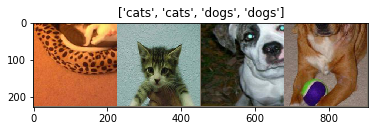

In [30]:
def imshow(inp, title=None):
    "Imshow for tensor"
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    
inputs, classes = next(iter(dset_loaders['train']))

out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[dset_classes[x] for x in classes[:4]])

In [101]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()
    
    best_model = model
    best_acc = 0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)
    
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_correct = 0.0

            iteration = 0
            for data in dset_loaders[phase]:
                inputs, labels = data
                
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.data[0]
                running_correct += torch.sum(preds == labels.data)
                
#                 if iteration % 20 == 0:
#                     print('{} Loss: {:4f}, Acc: {:4f}'.format
#                          phase, running_loss/20, running_correct/20)
#                     running_loss = 0
#                     running_correct = 0
            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_correct / dset_sizes[phase]
            print('{} Loss: {:4f} Acc: {:4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model

In [36]:
# def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
#     lr = init_lr * (0.1**(epoch // lr_decay_epoch))

#     if epoch % lr_decay_epoch == 0:
#         print('LR is set to {}'.format(lr))

#     for param_group in optimizer.param_group:
#         param_group['lr'] = lr

#     return optimizer

In [46]:
def visualize_model(model, num_image=6):
    images_so_far = 0
    fig = plt.figure()
    
    for i, data in enumerate(dset_loaders['valid']):
        inputs, labels = data
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_image//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dset_classes[preds[j][0]]))
            imshow(inputs.cpu().data[j])
            
            if images_so_far == num_image:
                return

## Fixed feature extractor

In [104]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

optimzer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

In [105]:
model_conv = train_model(model_conv, criterion, optimzer_conv,
                        num_epochs=10)

Epoch 0/9
----------
train Loss: 0.006458 Acc: 0.911429
valid Loss: 0.001852 Acc: 0.979333

Epoch 1/9
----------
train Loss: 0.004899 Acc: 0.933029
valid Loss: 0.001629 Acc: 0.982267

Epoch 2/9
----------
train Loss: 0.005047 Acc: 0.929943
valid Loss: 0.002193 Acc: 0.970000

Epoch 3/9
----------
train Loss: 0.004890 Acc: 0.932514
valid Loss: 0.002227 Acc: 0.971333

Epoch 4/9
----------
train Loss: 0.004838 Acc: 0.932514
valid Loss: 0.001508 Acc: 0.982267

Epoch 5/9
----------
train Loss: 0.004691 Acc: 0.935657
valid Loss: 0.001663 Acc: 0.980667

Epoch 6/9
----------
train Loss: 0.004749 Acc: 0.933257
valid Loss: 0.001609 Acc: 0.980267

Epoch 7/9
----------
train Loss: 0.004557 Acc: 0.938914
valid Loss: 0.001796 Acc: 0.977467

Epoch 8/9
----------
train Loss: 0.004582 Acc: 0.937086
valid Loss: 0.001625 Acc: 0.978800

Epoch 9/9
----------
train Loss: 0.004819 Acc: 0.933086
valid Loss: 0.001509 Acc: 0.982000

Training complete in 5m 50s
Best val Acc: 0.982267


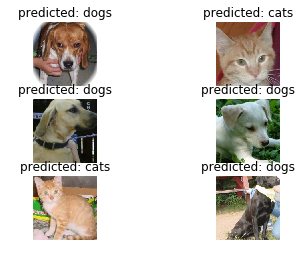

In [106]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## Test images and produce csv

In [55]:
from PIL import Image
class TestImageFolder(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        images = []
        for filename in os.listdir(root):
            if filename.endswith('jpg'):
                images.append('{}'.format(filename))
        
        self.root = root
        self.imgs = images
        self.transform = transform
    
    def __getitem__(self, index):
        filename = self.imgs[index]
        img = Image.open(os.path.join(self.root, filename))
        if self.transform is not None:
            img = self.transform(img)
        return img, filename
    
    def __len__(self):
        return len(self.imgs)

In [81]:
# Load test images
test_dir = '/home/andy/data/dog_vs_cat/test/'
test_transform = transforms.Compose(
    [transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
test_loader = torch.utils.data.DataLoader(TestImageFolder(root=test_dir, transform=test_transform),
                        batch_size=1, shuffle=True, num_workers=1, pin_memory=False)

In [107]:
# Test on the test dataset and output submission file
def produce_csv(model, test_loader):
    import csv
    csv_map = {} # 

    for i, (image, filepath) in enumerate(test_loader):
        number = os.path.splitext(os.path.basename(filepath[0]))[0]
        number = int(number)
        image_var = Variable(image.cuda(), volatile=True)
        y_pred = model(image_var)
        smax = nn.Softmax()
        y_pred = smax(y_pred)[0]
        dog_prob = y_pred.data[1]
        dog_prob = np.around(dog_prob, decimals=4)
        dog_prob = np.clip(dog_prob, .0001, .999)
        csv_map[number] = dog_prob


    with open(os.path.join('.', 'entry.csv'), 'w') as csvfile:
        fieldnames = ['id', 'label']
        csv_w = csv.writer(csvfile)
        csv_w.writerow(('id', 'label'))
        for row in sorted(csv_map.items()):
            csv_w.writerow(row)

In [108]:
produce_csv(model_conv, test_loader)

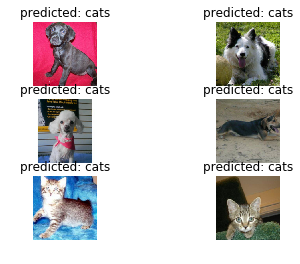

In [98]:
images_so_far = 0
fig = plt.figure()
num_image = 6

for i, data in enumerate(test_loader):
    inputs = data[0]

    inputs = Variable(inputs.cuda())
 
    outputs = model_conv(inputs)
    _, preds = torch.max(outputs.data, 1)

    for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_image//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(dset_classes[preds[j][0]]))
        imshow(inputs.cpu().data[j])
    if images_so_far == num_image:
        break

## Try to finetune the last conv layer

In [112]:
# Check the modules in the resnet
# So we find the last conv layer start from 50 index
for idx, m in enumerate(model_conv.named_modules()):
         print(idx, '->', m)


0 -> ('', ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): B

In [118]:
model_conv_ft = torchvision.models.resnet18(pretrained=True)

count = 0
# Fine tune layer 4
for name, param in model_conv.named_parameters():
    count += 1
    if count == 55:
        print('Fix until {}, Count: {}'.format(name, count))
        break
    param.requires_grad = False
    
    
num_ftrs = model_conv_ft.fc.in_features
model_conv_ft.fc = nn.Linear(num_ftrs, 2)


model_conv_ft = model_conv_ft.cuda()

criterion = nn.CrossEntropyLoss()

optimzer_conv_fc = optim.Adam(model_conv_ft.fc.parameters(), lr=0.001)

Fix until layer4.1.conv1.weight, Count: 55


In [120]:
model_conv_ft = train_model(model_conv_ft, criterion, optimzer_conv_fc,
                        num_epochs=10)

Epoch 0/9
----------
train Loss: 0.004442 Acc: 0.940514
valid Loss: 0.001439 Acc: 0.982667

Epoch 1/9
----------
train Loss: 0.004430 Acc: 0.940857
valid Loss: 0.001451 Acc: 0.982667

Epoch 2/9
----------
train Loss: 0.004549 Acc: 0.938057
valid Loss: 0.001460 Acc: 0.982133

Epoch 3/9
----------
train Loss: 0.004587 Acc: 0.937143
valid Loss: 0.001443 Acc: 0.982533

Epoch 4/9
----------
train Loss: 0.004372 Acc: 0.939600
valid Loss: 0.001441 Acc: 0.982533

Epoch 5/9
----------
train Loss: 0.004565 Acc: 0.937314
valid Loss: 0.001431 Acc: 0.982267

Epoch 6/9
----------
train Loss: 0.004362 Acc: 0.938457
valid Loss: 0.001436 Acc: 0.982667

Epoch 7/9
----------
train Loss: 0.004254 Acc: 0.940914
valid Loss: 0.001446 Acc: 0.983600

Epoch 8/9
----------
train Loss: 0.004401 Acc: 0.940286
valid Loss: 0.001460 Acc: 0.982533

Epoch 9/9
----------
train Loss: 0.004323 Acc: 0.939714
valid Loss: 0.001436 Acc: 0.982533

Training complete in 10m 48s
Best val Acc: 0.983600


In [121]:
produce_csv(model_conv_ft, test_loader)